In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# import xgboost as xgb
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
import pickle

In [2]:
data_transformers = dict()

# Helpfull functions

In [3]:
TARGET = 'Leistungseintritt'

def drow_hist(df, col):
    plt.hist(df[col], bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f'Hist of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.show()

def drow_kde_by_target(df, col):
    sns.displot(
        {
            f'{col}_LI = 1': df[df[TARGET] == 1][col],
            f'{col}_LI = 0': df[df[TARGET] == 0][col]
        },
        kind='kde',
        common_norm=False
    )
    plt.title(f'Leistungseintritt - {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def drow_boxplot_by_target(df, col):
    sns.boxplot(
        y=col,
        x=TARGET,
        data=df
    )
    plt.title(f'{col} - {TARGET}')

def is_norm(df, col):
    # Statistical test: Shapiro-Wilk test for normality
    shapiro_test = stats.shapiro(df['Reisedauer'].sample(min(5000, len(df))))  # Use a sample for large datasets
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    
    # Statistical test: Kolmogorov-Smirnov test
    ks_test = stats.kstest(df['Reisedauer'], 'norm', args=(df['Reisedauer'].mean(), df['Reisedauer'].std()))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

# Import Data

In [4]:
df = pd.read_csv('reiseversicherung.csv')
df

,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agenturname        63326 non-null  object 
 1   Agenturtyp         63326 non-null  object 
 2   Vertriebskanal     63326 non-null  object 
 3   Produktname        63326 non-null  object 
 4   Leistungseintritt  63326 non-null  object 
 5   Reisedauer         63326 non-null  int64  
 6   Reiseziel          63326 non-null  object 
 7   Nettoumsatz        63326 non-null  float64
 8   Kommission         63326 non-null  float64
 9   Geschlecht         18219 non-null  object 
 10  Alter              63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [6]:
for col in df.columns[df.dtypes == 'object']:
    print(f'Spalte: {col} \t\t hat {df[col].nunique()} unique values')

Spalte: Agenturname 		 hat 16 unique values
Spalte: Agenturtyp 		 hat 2 unique values
Spalte: Vertriebskanal 		 hat 2 unique values
Spalte: Produktname 		 hat 26 unique values
Spalte: Leistungseintritt 		 hat 2 unique values
Spalte: Reiseziel 		 hat 149 unique values
Spalte: Geschlecht 		 hat 2 unique values


In [7]:
df.describe()

,Reisedauer,Nettoumsatz,Kommission,Alter
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


### Commentar
- in der Spalte Geschlecht fehlen Werte (~70%)
- viele Spalten sind vom Typ Objekt
- einige Spalten haben 2 Unique values und können mit 1 und 0 gekennzeichnet werden
- es ist merkwürdig, dass die Spalten Nettoumsatz und Reisedauer negative Werte haben können
- die Höchstwerte von Reisedauer(4881) und Alter(118) sehen merkwürdig aus

# Leistungseintritt 

In [8]:
# in ein binäres Zeichen umwandeln
print(df['Leistungseintritt'].value_counts())
df['Leistungseintritt'] = df['Leistungseintritt'].map({
    'Yes': 1,
    'No': 0
})
print(f'Leistungseintritt mean: {df['Leistungseintritt'].mean()}')

Leistungseintritt
No     62399
Yes      927
Name: count, dtype: int64
Leistungseintritt mean: 0.014638537093768752


### Commentar
- nur 1.46 % der Daten werden als Zielklasse klassifiziert

# Vertriebskanal

In [9]:
data_transformers['Vertriebskanal'] = {
    'Online': 1, 
    'Offline': 0
}

print(df['Vertriebskanal'].value_counts())
df['Vertriebskanal'] = df['Vertriebskanal'].map(
    data_transformers['Vertriebskanal']
)

print(f'Vertriebskanal mean: {df['Vertriebskanal'].mean()}')

Vertriebskanal
Online     62219
Offline     1107
Name: count, dtype: int64
Vertriebskanal mean: 0.9825190285190917


# Reisedauer

count    63326.000000
mean        49.317074
std        101.791566
min         -2.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Reisedauer, dtype: float64


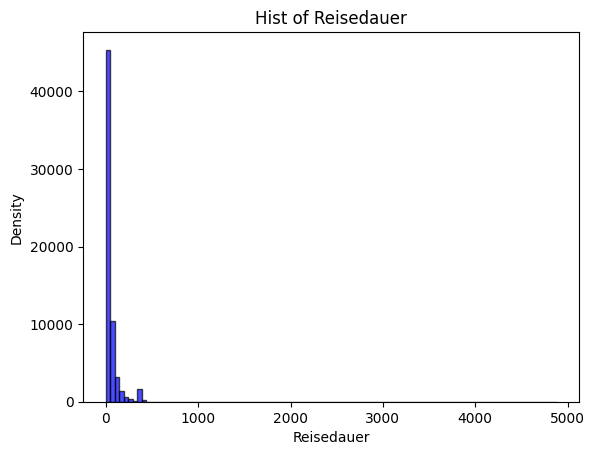

Shapiro-Wilk Test: Statistic=0.3687242764322013, p-value=2.8545285361201034e-85
Kolmogorov-Smirnov Test: Statistic=0.316470028707683, p-value=0.0


In [10]:
print(df['Reisedauer'].describe())
drow_hist(df, 'Reisedauer')
is_norm(df, 'Reisedauer')

In [11]:
print(f'Mean Leistungseintritt: {df[df['Reisedauer'] > 450]['Leistungseintritt'].mean()}')
df[df['Reisedauer'] > 450].head()

Mean Leistungseintritt: 0.0


,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
3025,SSI,Airlines,1,Ticket Protector,0,4881,SINGAPORE,0.13,0.04,NaN,48
6847,SSI,Airlines,1,Ticket Protector,0,4857,SINGAPORE,0.32,0.09,NaN,48
8686,SSI,Airlines,1,Ticket Protector,0,4847,SINGAPORE,0.32,0.09,NaN,48
9232,SSI,Airlines,1,Ticket Protector,0,4844,SINGAPORE,0.32,0.09,NaN,48
12059,SSI,Airlines,1,Ticket Protector,0,4831,SINGAPORE,0.32,0.09,NaN,48


In [12]:
df = df.drop(df[df['Reisedauer'] > 450].index)

In [13]:
print(f'Mean Leistungseintritt: {df[df['Reisedauer'] < 0]['Leistungseintritt'].mean()}')
df[df['Reisedauer'] < 0]

Mean Leistungseintritt: 0.0


,Agenturname,Agenturtyp,Vertriebskanal,Produktname,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Geschlecht,Alter
14943,JZI,Airlines,1,Basic Plan,0,-2,BANGLADESH,22.0,7.7,M,118
52587,JZI,Airlines,1,Basic Plan,0,-1,MALAYSIA,18.0,6.3,NaN,118
52588,JZI,Airlines,1,Basic Plan,0,-1,BRUNEI DARUSSALAM,18.0,6.3,NaN,118
56668,JZI,Airlines,1,Basic Plan,0,-1,INDONESIA,18.0,6.3,NaN,118
59528,JZI,Airlines,1,Basic Plan,0,-1,CHINA,22.0,7.7,NaN,118


In [14]:
df = df.drop(df[df['Reisedauer'] < 0].index)

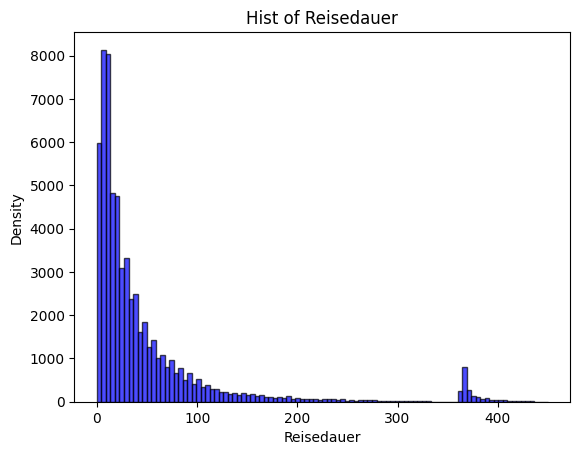

In [15]:
drow_hist(df, 'Reisedauer')

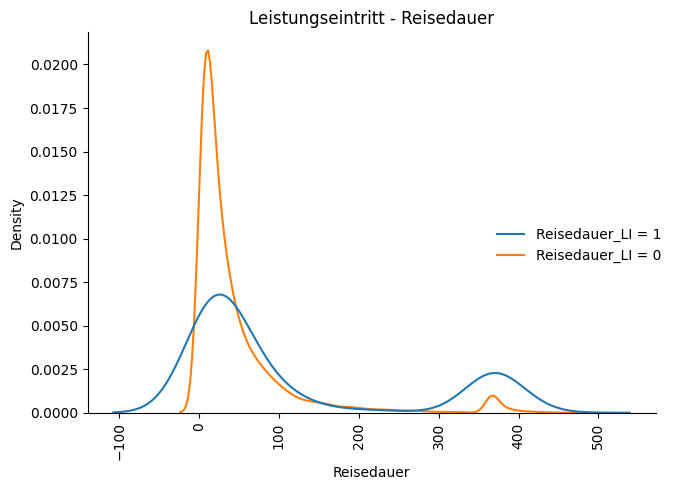

In [16]:
drow_kde_by_target(df, 'Reisedauer')

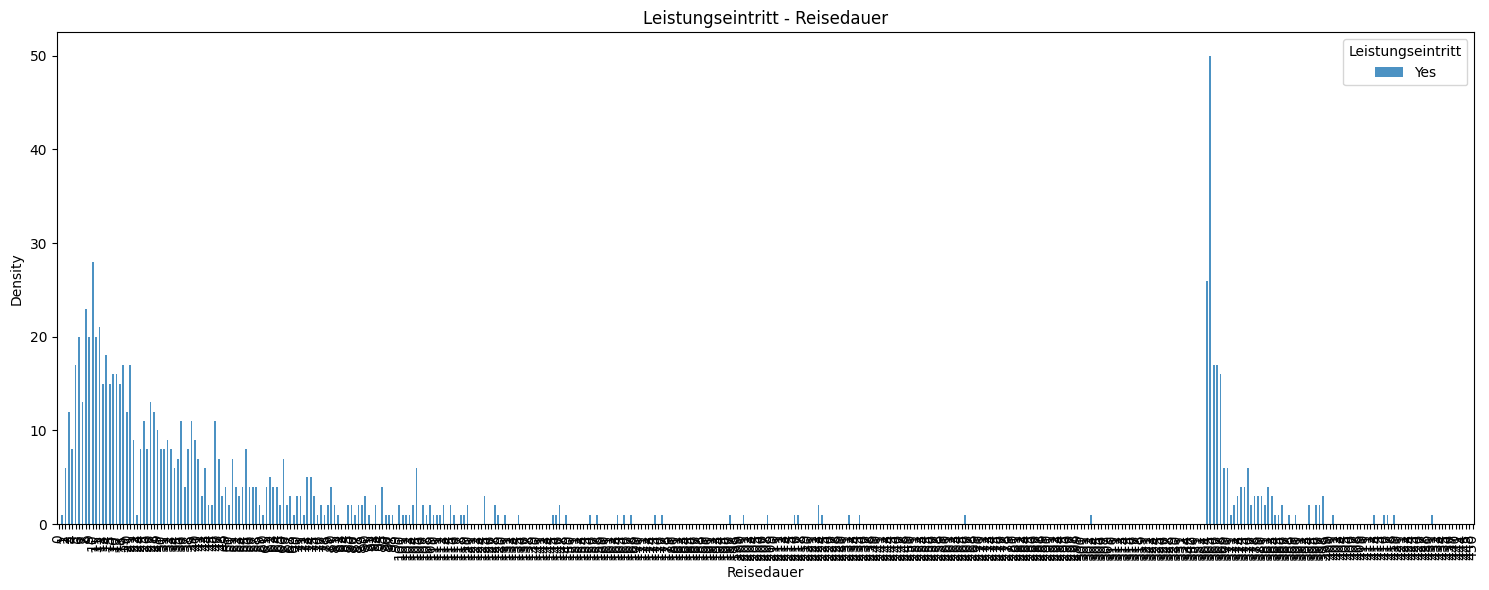

In [17]:
rd_claims = df.groupby(['Reisedauer', 'Leistungseintritt']).size().unstack(fill_value=0)

rd_claims[1].plot(kind='bar', stacked=True, figsize=(15, 6), alpha=0.8)
plt.title('Leistungseintritt - Reisedauer')
plt.xlabel('Reisedauer')
plt.ylabel('Density')
plt.legend(title='Leistungseintritt', labels=['Yes'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

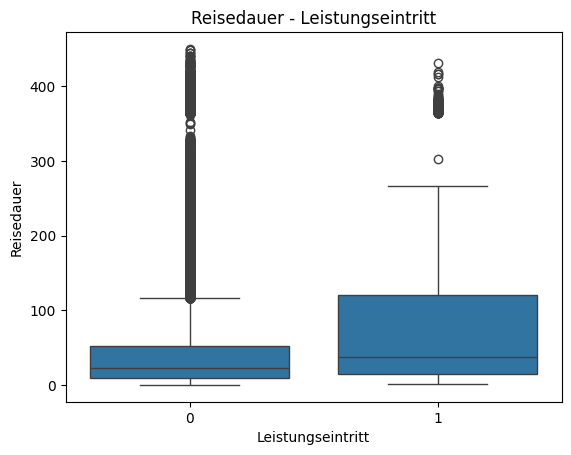

In [18]:
drow_boxplot_by_target(df, 'Reisedauer')

In [19]:
df['ReisedauerLog'] = df['Reisedauer'].apply(lambda x: np.log1p(x) if x > 0 else 0)
# drow_hist(df, 'ReisedauerLog')
is_norm(df, 'ReisedauerLog')

df['ReisedauerSqrt'] = df['Reisedauer'].apply(lambda x: np.sqrt(x) if x > 0 else 0)
# drow_hist(df, 'ReisedauerSqrt')
is_norm(df, 'ReisedauerSqrt')

df['ReisedauerInv'] = df['Reisedauer'].apply(lambda x: 1/x if x > 0 else 0)
# drow_hist(df, 'ReisedauerInv')
is_norm(df, 'ReisedauerInv')

Shapiro-Wilk Test: Statistic=0.5834816403500405, p-value=3.001984833529423e-76
Kolmogorov-Smirnov Test: Statistic=0.25902675579546164, p-value=0.0
Shapiro-Wilk Test: Statistic=0.5848340075235423, p-value=3.515102010222304e-76
Kolmogorov-Smirnov Test: Statistic=0.25902675579546164, p-value=0.0
Shapiro-Wilk Test: Statistic=0.5911413005420671, p-value=7.380829316304306e-76
Kolmogorov-Smirnov Test: Statistic=0.25902675579546164, p-value=0.0


In [20]:
df['LangeReise'] = df['Reisedauer'] > 363
df['LangeReise'] = df['LangeReise'].astype(int)

### Commentar
- es ist definitiv keine Normalverteilung
- gelöschte Beispiele mit Reisedauer mehr als 450 und weniger als 0 Tage
- die Verteilung sieht jetzt viel besser aus, hat aber immer noch einen langen Schwanz
- die Daten in 2 Teilmengen unterteilt sind, die zweite beginnt etwa am Tag 363
- WICHTIG! die Anzahl der Leistungseintritte in der zweiten Teilgruppe ist höher als in der ersten Teilgruppe
- der Leistungseintritt ist bei kurzen Reisen seltener erforderlich als bei langen Reisen (länger als 363 Tage)
-
- die LangeReise - Spalte hinzugefügt
-
- abgeleitete Merkmale wie Reisedauer_log, Reisedauer_sqrt, Reisedauer_inv wurden erstellt 
- keine der Spalten erhielt eine Normalverteilung

# Alter

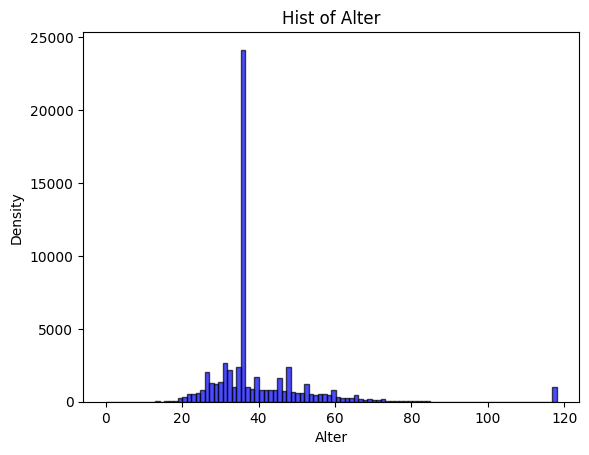

Shapiro-Wilk Test: Statistic=0.595058917833697, p-value=1.1758859647966274e-75
Kolmogorov-Smirnov Test: Statistic=0.25902675579546164, p-value=0.0


count    63276.000000
mean        39.961518
std         14.001979
min          0.000000
25%         35.000000
50%         36.000000
75%         43.000000
max        118.000000
Name: Alter, dtype: float64

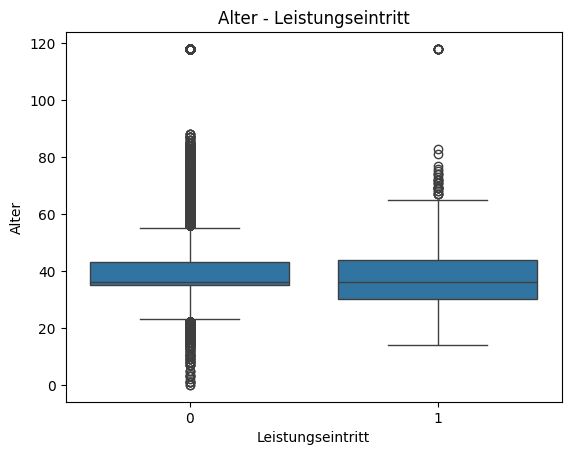

In [21]:
drow_hist(df, 'Alter')
drow_boxplot_by_target(df, 'Alter')
is_norm(df, 'Alter')
df['Alter'].describe()

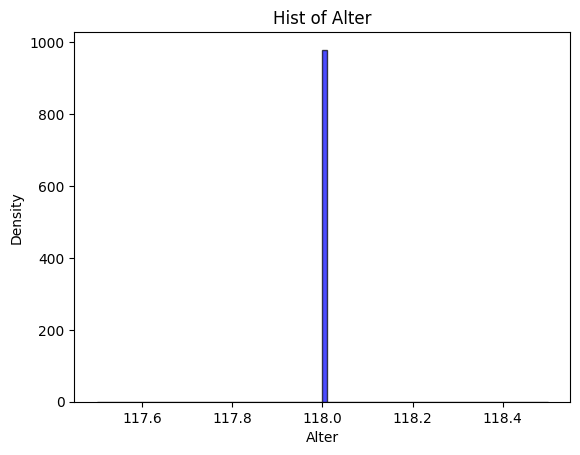

0.010214504596527068


In [22]:
wertgrenze = 90
drow_hist(df[df['Alter'] > wertgrenze], 'Alter')
print(df[df['Alter'] > wertgrenze]['Leistungseintritt'].mean())

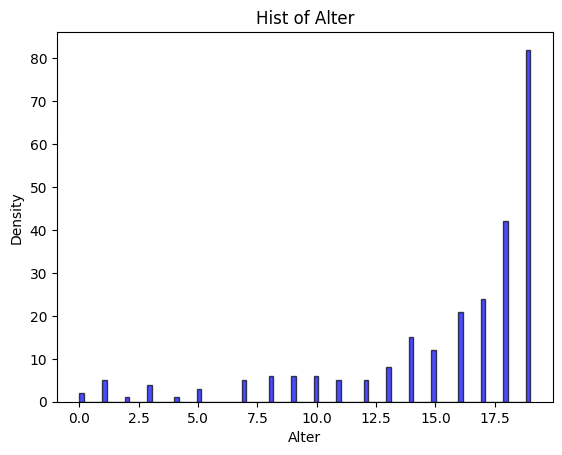

0.02766798418972332


In [23]:
wertgrenze = 20
drow_hist(df[df['Alter'] < wertgrenze], 'Alter')
print(df[df['Alter'] < wertgrenze]['Leistungseintritt'].mean())

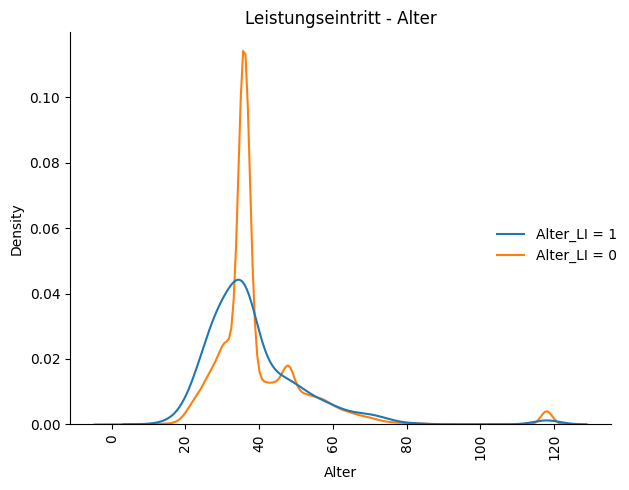

In [24]:
drow_kde_by_target(df, 'Alter')

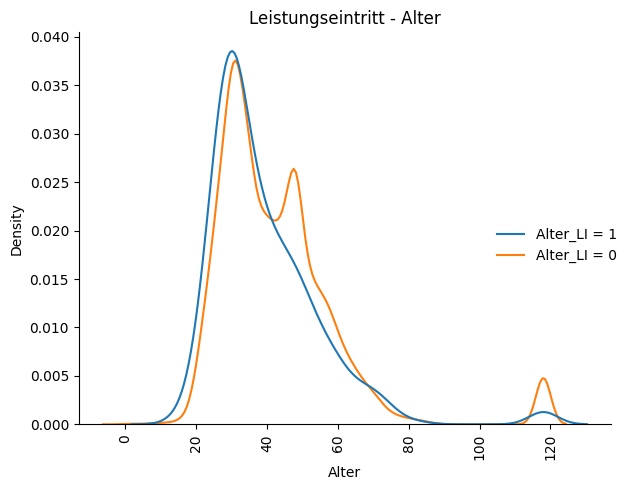

In [25]:
drow_kde_by_target(df[df['Alter']!=36], 'Alter')

### Commentar
- die große Anzahl von Personen im Alter von 36 Jahren könnte darauf hindeuten, dass dies eine Auffüllung von fehlenden Werten war
- die große Anzahl von Personen im Alter von 118 Jahren könnte darauf hindeuten, dass dies als Ersatz für zu hohe Werte verwendet wurde
- diese Daten(118) können nicht gelöscht werden, da sie einen ähnlichen Prozentsatz des Zielmerkmals enthalten wie der gesamte Datensatz
- wenn man die Beispiele im Alter von 36 Jahren nicht berücksichtigt, sehen die Diagramme des Zielmerkmals sehr ähnlich aus

# Nettoumsatz, Kommission

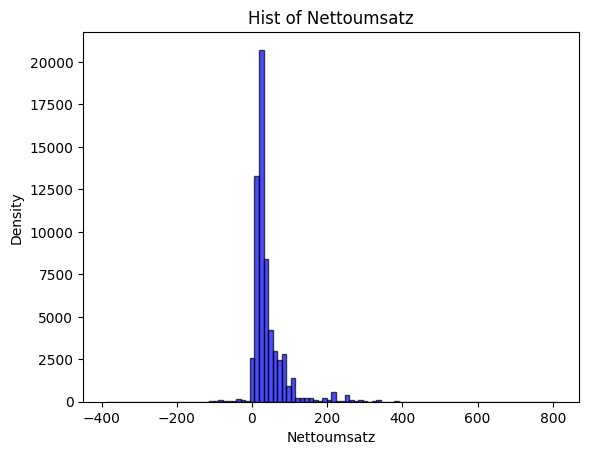

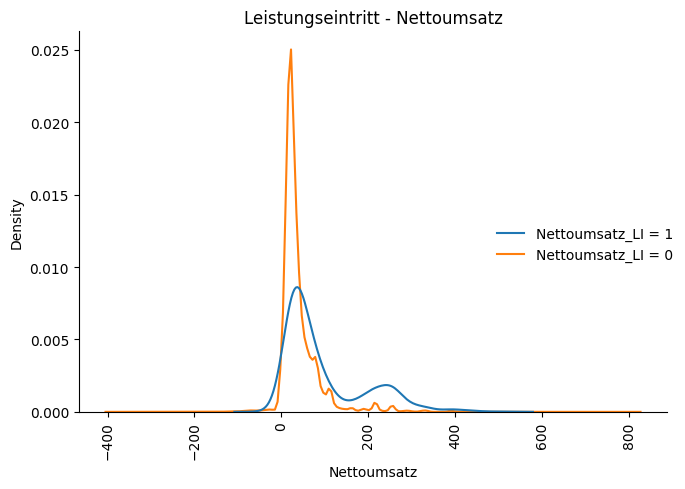

Shapiro-Wilk Test: Statistic=0.5754902220295306, p-value=1.1920943326201758e-76
Kolmogorov-Smirnov Test: Statistic=0.25902675579546164, p-value=0.0


count    63276.000000
mean        40.626697
std         48.692668
min       -389.000000
25%         18.000000
50%         26.500000
75%         48.000000
max        810.000000
Name: Nettoumsatz, dtype: float64

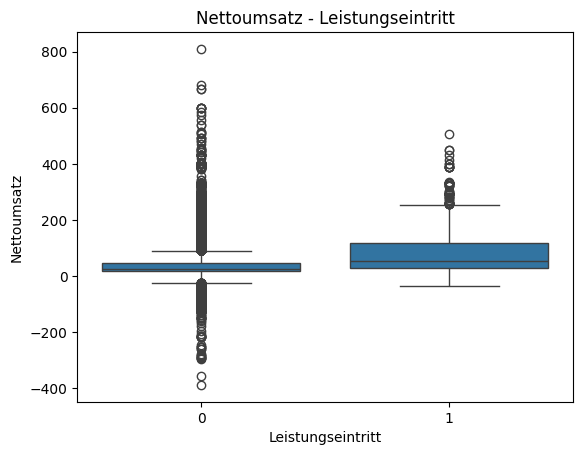

In [26]:
drow_hist(df, 'Nettoumsatz')
drow_kde_by_target(df, 'Nettoumsatz')
drow_boxplot_by_target(df, 'Nettoumsatz')
is_norm(df, 'Nettoumsatz')
df['Nettoumsatz'].describe()

In [27]:
df[df['Nettoumsatz'] == 0].shape

(1883, 15)

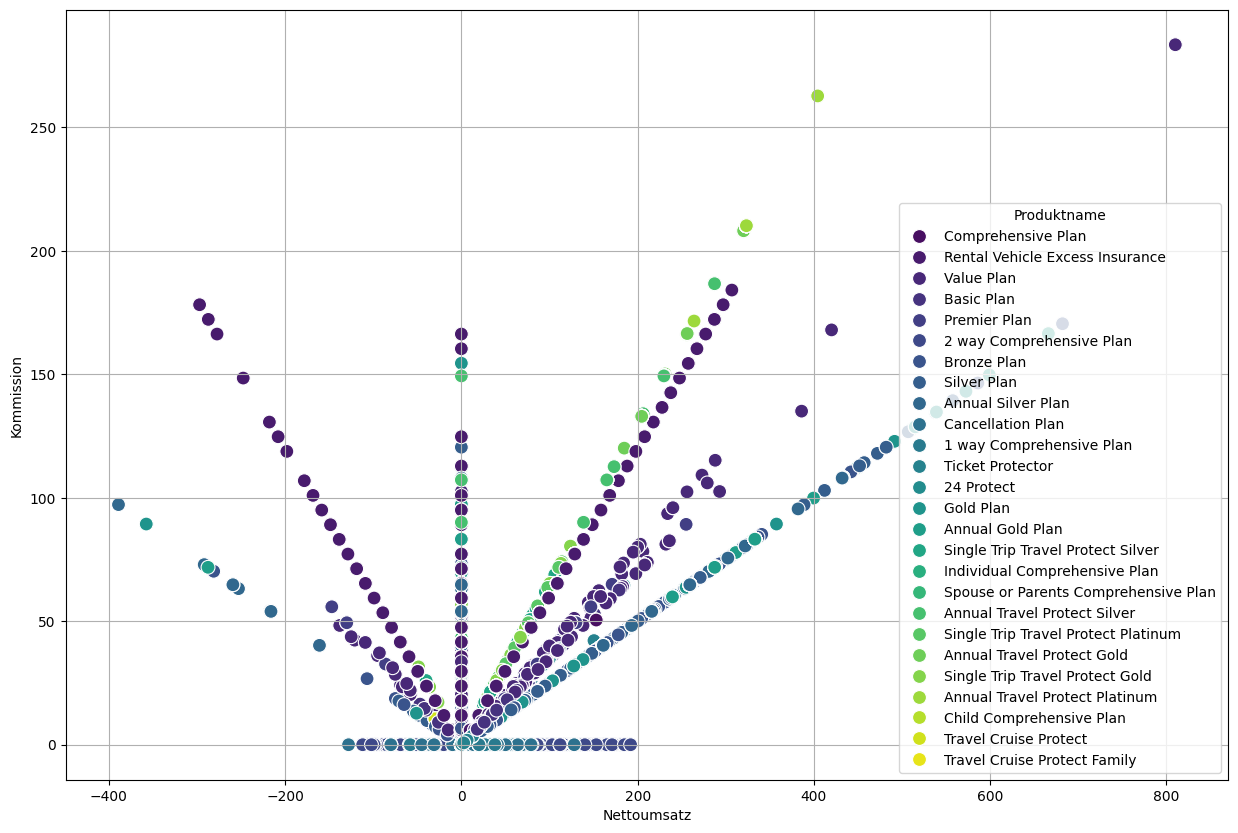

In [28]:
import seaborn as sns

# Scatter plot с hue
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='Nettoumsatz', y='Kommission', hue='Produktname', palette='viridis', s=100)
plt.xlabel('Nettoumsatz')
plt.ylabel('Kommission')
plt.grid(True)
plt.show()

In [29]:
# speichern die Information über das Vorzeichen von Nettoumsatz in einer neuen Spalte
df['NettoumsatzLt0'] = (df['Nettoumsatz'] < 0).astype(int)

In [30]:
# machen alle Werte von Nettoumsatz positiv
df['Nettoumsatz'] = df['Nettoumsatz'].abs()

In [31]:
df = df.drop(df[df['Produktname'] == "Travel Cruise Protect Family"].index)

In [32]:
# gruppieren nach dem Produktnamen und berechnen das Verhältnis von Kommission zu Nettoumsatz. 
# Anschließend fügen wir dieses Verhältnis als zusätzliches Merkmal hinzu.
kommission_ratios = df[df['Nettoumsatz'] != 0].groupby('Produktname').apply(
    lambda group: (group['Kommission'] / group['Nettoumsatz']).mean().round(3), include_groups=False
)

data_transformers['KommissionNettoumsatzRatio'] = dict(kommission_ratios)

# set(df['Produktname'].unique()) - set(kommission_ratios.keys())
df['KommissionNettoumsatzRatio'] = df['Produktname'].map(
    data_transformers['KommissionNettoumsatzRatio']
)

In [33]:
df = df.drop(columns=['Produktname'])

### Commentar
- bei einem höheren Nettoumsatz ist der Prozentsatz der Zielvariable höher
- es sind negative Werte vorhanden
- der Nettoumsatz gleich 0 sein, während die Kommission nicht immer null ist
- es gibt insgesamt 3 Beispiele in den Daten, bei denen die Zielvariable gleich 1 ist und der Nettoumsatz < 0 beträgt
- kommission und Nettoumsatz sind linear voneinander abhängig, jedoch gibt es auch Fälle, in denen Nettoumsatz = 0 und Kommission ≠ 0 ist und umgekehrt


# Geschlecht

Eintrittswahrscheinlichkeit nach Geschlecht:
Geschlecht
F          0.039074
M          0.031401
Unknown    0.006387
Name: Leistungseintritt, dtype: float64


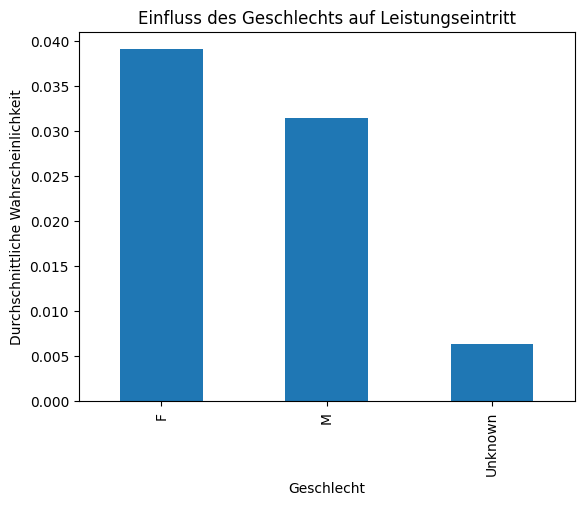

In [34]:
df['Geschlecht'] = df['Geschlecht'].fillna('Unknown')

gender_impact = df.groupby('Geschlecht')['Leistungseintritt'].mean()

print("Eintrittswahrscheinlichkeit nach Geschlecht:")
print(gender_impact)

gender_impact.plot(kind='bar', title='Einfluss des Geschlechts auf Leistungseintritt')
plt.ylabel('Durchschnittliche Wahrscheinlichkeit')
plt.show()

In [35]:
df['Mann'] = (df['Geschlecht'] == 'M').astype(int)
df['Frau'] = (df['Geschlecht'] == 'F').astype(int)
df = df.drop(columns=['Geschlecht'])

### Commentar
- das Geschlecht ist ein wichtiger Parameter, dessen Vorhandensein die Wahrscheinlichkeit des Leistungseintritt mehr als verdoppelt
- dieser Parameter ist nicht bei allen Beispielen vorhanden, und leider gibt es keine Möglichkeit, ihn zu ergänzen
- führen ein One-Hot-Encoding für Mann und Frau durch, um die Information über fehlende Geschlechtsangaben zu erhalten

# Agenturtyp

In [36]:
df['Agenturtyp'].value_counts()

Agenturtyp
Travel Agency    45856
Airlines         17419
Name: count, dtype: int64

In [67]:
data_transformers['Agenturtyp'] = {
    'Travel Agency': 0,
    'Airlines': 1
}

df['Agenturtyp'] = df['Agenturtyp'].map(
    data_transformers['Agenturtyp']
)

In [38]:
grouped = df.groupby([TARGET, 'Agenturtyp']).size()
ratios = grouped / grouped.groupby(level=1).sum()
print(ratios[1])

Agenturtyp
0    0.007327
1    0.033928
dtype: float64


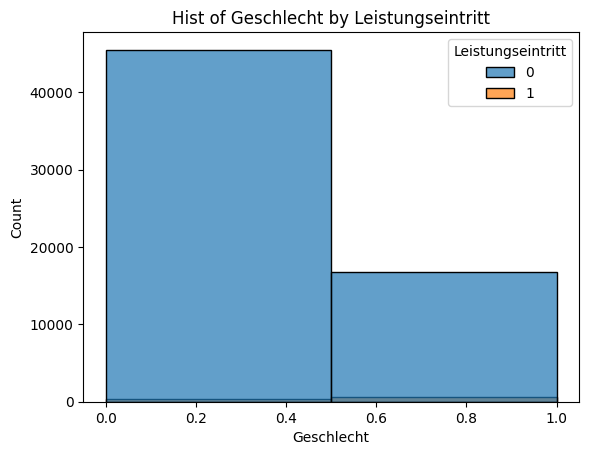

In [39]:
sns.histplot(data=df, x='Agenturtyp', hue=TARGET, bins=2, kde=False, edgecolor='black', alpha=0.7)

plt.title(f'Hist of {col} by Leistungseintritt')
plt.xlabel(f'{col}')
plt.ylabel('Count')
plt.show()

### Commentar
- für Leistungseintritt wenden sich Kunden fast fünfmal häufiger an Airlines als an Travel Agencies.


# Agenturname

In [40]:
total_trips = df.groupby('Agenturname').size().reset_index(name='TotalTrips')

refund_requests = df[df[TARGET] == 1].groupby('Agenturname').size().reset_index(name='RefundRequests')

summary = pd.merge(total_trips, refund_requests, on='Agenturname', how='left')

summary['RefundPercentage'] = (summary['RefundRequests'] / summary['TotalTrips']) * 100
summary['RefundRequests'] = summary['RefundRequests'].fillna(0)
summary['RefundPercentage'] = summary['RefundPercentage'].fillna(0)


summary = summary.sort_values(by='RefundPercentage', ascending=False)
summary.head(20)

,Agenturname,TotalTrips,RefundRequests,RefundPercentage
2,C2B,8248,547.0,6.631911
11,LWC,677,36.0,5.317578
15,TTW,98,4.0,4.081633
10,KML,392,8.0,2.040816
4,CCR,194,3.0,1.546392
5,CSR,86,1.0,1.162791
6,CWT,8580,86.0,1.002331
3,CBH,101,1.0,0.990099
13,SSI,1042,7.0,0.671785
7,EPX,35119,195.0,0.555255


In [41]:
data_transformers['RueckerstattungsprozentsatzNachAgenturname'] = dict(summary[['Agenturname', 'RefundPercentage']].set_index('Agenturname'))['RefundPercentage']

In [42]:
for an in df['Agenturname'].unique():
    RefundPercentageByAgenturname = summary.loc[summary['Agenturname'] == an, 'RefundPercentage'].values[0]
    df.loc[df['Agenturname'] == an, 'RueckerstattungsprozentsatzNachAgenturname'] = RefundPercentageByAgenturname

In [43]:
df = df.drop(columns=['Agenturname'])

# Reiseziel

In [44]:
df[df[TARGET] == 1]['Reiseziel'].value_counts().head(10)

Reiseziel
SINGAPORE              562
CHINA                   46
AUSTRALIA               38
UNITED STATES           37
THAILAND                34
MALAYSIA                23
UNITED KINGDOM          16
INDONESIA               15
'KOREA REPUBLIC OF'     15
HONG KONG               15
Name: count, dtype: int64

In [45]:
df['Reiseziel'].value_counts()

Reiseziel
SINGAPORE                 13222
MALAYSIA                   5928
THAILAND                   5894
CHINA                      4793
AUSTRALIA                  3694
                          ...  
GUATEMALA                     1
TIBET                         1
SENEGAL                       1
REPUBLIC OF MONTENEGRO        1
BOSNIA AND HERZEGOVINA        1
Name: count, Length: 149, dtype: int64

In [46]:
pivot_table = df.groupby('Reiseziel').agg(
    total_policies=('Leistungseintritt', 'count'),
    total_claims=('Leistungseintritt', lambda x: (x == 1).sum())
)

pivot_table['claim_ratio'] = (pivot_table['total_claims'] / pivot_table['total_policies']).round(3)

global_risk = df[TARGET].mean()
W = 10
pivot_table['weighted_claim_ratio'] = ((global_risk * W + pivot_table['total_claims']) / (W + pivot_table['total_policies'])).round(3)

pivot_table = pivot_table.sort_values(by='weighted_claim_ratio', ascending=False)

pivot_table.head(10)

,total_policies,total_claims,claim_ratio,weighted_claim_ratio
Reiseziel,,,,
COSTA RICA,7,1,0.143,0.067
BULGARIA,12,1,0.083,0.052
SINGAPORE,13222,562,0.043,0.042
ARGENTINA,22,1,0.045,0.036
SOUTH AFRICA,162,5,0.031,0.030
CZECH REPUBLIC,69,2,0.029,0.027
ICELAND,117,3,0.026,0.025
NEPAL,120,3,0.025,0.024
ITALY,455,9,0.020,0.020


In [47]:
data_transformers['ReisezielLeistungseintrittRatio'] = dict(pivot_table[['claim_ratio']])['claim_ratio']
data_transformers['GewichtetReisezielLeistungseintrittRatio'] = dict(pivot_table[['weighted_claim_ratio']])['weighted_claim_ratio']

In [48]:
df = df.merge(
    pivot_table[['claim_ratio', 'weighted_claim_ratio']],
    on='Reiseziel',
    how='left'
)

df.head()

,Agenturtyp,Vertriebskanal,Leistungseintritt,Reisedauer,Reiseziel,Nettoumsatz,Kommission,Alter,ReisedauerLog,ReisedauerSqrt,ReisedauerInv,LangeReise,NettoumsatzLt0,KommissionNettoumsatzRatio,Mann,Frau,RueckerstattungsprozentsatzNachAgenturname,claim_ratio,weighted_claim_ratio
0,0,0,0,186,MALAYSIA,29.0,9.57,81,5.231109,13.638182,0.005376,0,1,0.33,0,1,0.990099,0.004,0.004
1,0,0,0,186,MALAYSIA,29.0,9.57,71,5.231109,13.638182,0.005376,0,1,0.33,0,1,0.990099,0.004,0.004
2,0,1,0,65,AUSTRALIA,49.5,29.70,32,4.189655,8.062258,0.015385,0,1,0.60,0,0,1.002331,0.010,0.010
3,0,1,0,60,AUSTRALIA,39.6,23.76,32,4.110874,7.745967,0.016667,0,1,0.60,0,0,1.002331,0.010,0.010
4,0,1,0,79,ITALY,19.8,11.88,41,4.382027,8.888194,0.012658,0,1,0.60,0,0,1.002331,0.020,0.020


In [49]:
df = df.rename(columns={"claim_ratio": "ReisezielLeistungseintrittRatio", 
                   "weighted_claim_ratio": "GewichtetReisezielLeistungseintrittRatio"})

In [50]:
df = df.drop(columns=['Reiseziel'])

# DF optimization

In [51]:
def optimize_dataframe(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in ['int64', 'int32']:
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        elif col_type == 'float64':
            df[col] = df[col].astype(np.float32)
        
    return df

print(f"Before optimization: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
optimize_dataframe(df)
print(f"After optimization: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Before optimization: 8.69 MB
After optimization: 2.78 MB


# Correlations

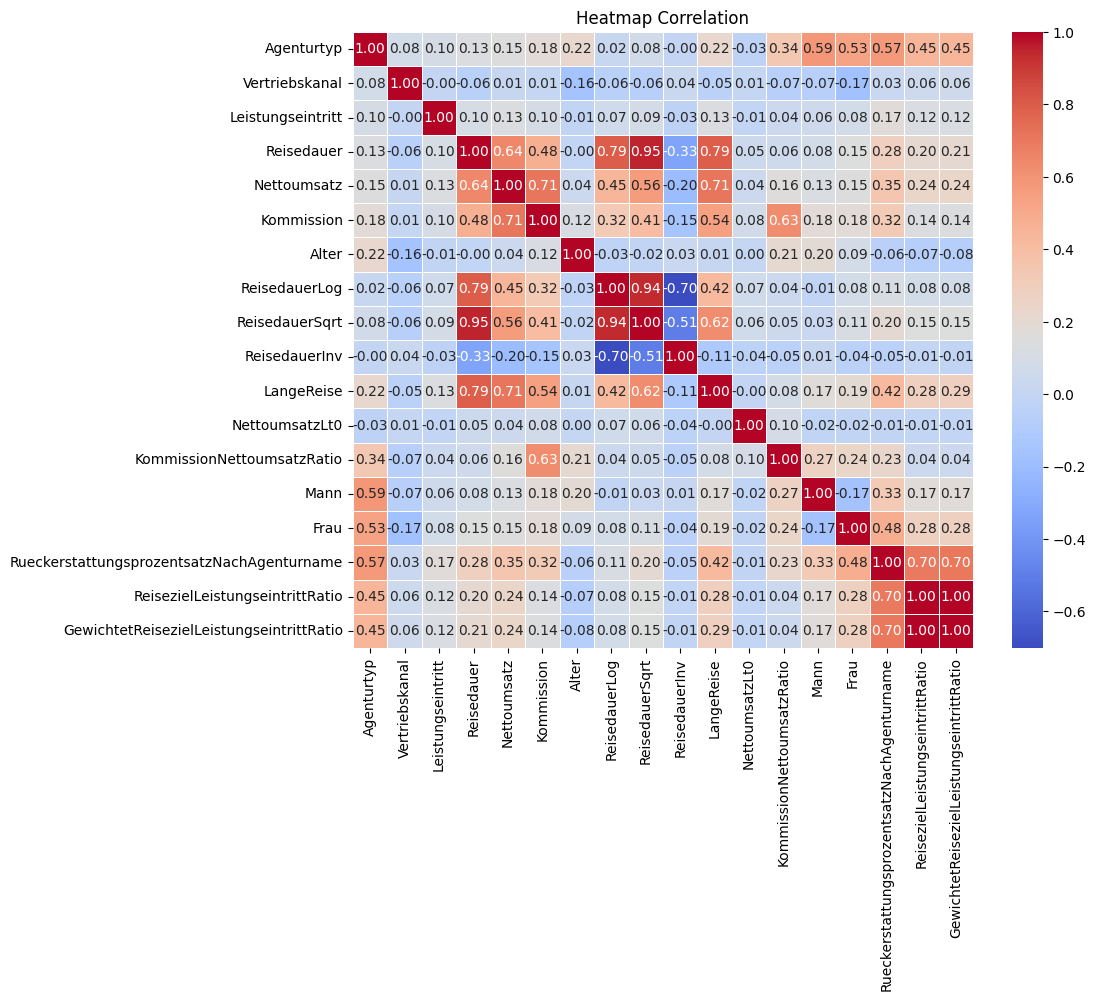

In [52]:
correlation_matrix = df.corr()

# Построение heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Correlation")
plt.show()

# Train models

In [53]:
y = df['Leistungseintritt']
X = df.drop(columns=['Leistungseintritt'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [54]:
def get_roc(y_pred_prob, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def get_scores(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.3f}")
    
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.3f}")

def estimate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    print(y_pred_prob.max())
    
    get_scores(y_pred, y_test)
    get_roc(y_pred_prob, y_test)
        
    for i in range(1, 21):
        lower_bound = 0.05 * (i - 1)
        upper_bound = 0.05 * i
        
        in_interval = (y_pred_prob >= lower_bound) & (y_pred_prob < upper_bound)
        samples_in_interval = in_interval.sum()
        
        samples_till_cutoff = (y_pred_prob < upper_bound).sum()
        
        true_in_interval = y_test[in_interval].sum()
        mean_true_in_interval = y_test[in_interval].mean()
        
        print(f'''{upper_bound*100:.0f}%\t- {samples_till_cutoff}, \t {lower_bound*100:.0f}-{upper_bound*100:.0f}% - {samples_in_interval}, \t True sum: {true_in_interval} \t True mean: {mean_true_in_interval:.2f}''')

In [55]:
# model = xgb.XGBClassifier(
#     n_estimators=100,
#     scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
#     random_state=42,
#     eval_metric='logloss'
# )

# model.fit(X_train, y_train)

In [56]:
# Search
# param_grid = {
#     'n_estimators': [75, 100, 150, 200],
#     'max_depth': [7, 10, 12],
#     'learning_rate': [0.01, 0.02, 0.1],
#     'num_leaves': [15, 30, 45],
#     'subsample': [0.3, 0.5],
#     'colsample_bytree': [0.4, 0.6]
# }

param_grid = {
    'colsample_bytree': [0.4],
    'learning_rate': [0.01],
    'max_depth': [10],
    'n_estimators': [100],
    'num_leaves': [45],
    'subsample': [0.3]
}

grid_search = GridSearchCV(
    estimator=LGBMClassifier(
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        random_state=42
    ),
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print(f"Best F1-Score on cv: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 695, number of negative: 46761
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 47456, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014645 -> initscore=-4.208893
[LightGBM] [Info] Start training from score -4.208893
Best params: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 45, 'subsample': 0.3}
Best F1-Score on cv: 0.149


In [57]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 100,
 'num_leaves': 45,
 'subsample': 0.3}

In [58]:
lgb_classifier = best_model

0.5686999583914715
TP: 109, FP: 1166, TN: 14421, FN: 123
Recall: 0.470
F1-Score: 0.145


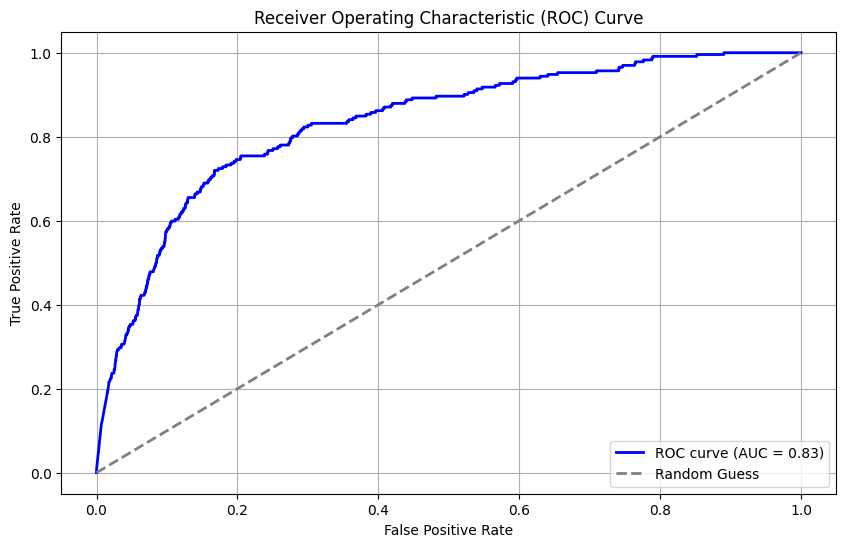

5%	- 3619, 	 0-5% - 3619, 	 True sum: 5 	 True mean: 0.00
10%	- 6908, 	 5-10% - 3289, 	 True sum: 14 	 True mean: 0.00
15%	- 9127, 	 10-15% - 2219, 	 True sum: 11 	 True mean: 0.00
20%	- 10539, 	 15-20% - 1412, 	 True sum: 9 	 True mean: 0.01
25%	- 11765, 	 20-25% - 1226, 	 True sum: 15 	 True mean: 0.01
30%	- 12764, 	 25-30% - 999, 	 True sum: 8 	 True mean: 0.01
35%	- 13356, 	 30-35% - 592, 	 True sum: 13 	 True mean: 0.02
40%	- 13651, 	 35-40% - 295, 	 True sum: 6 	 True mean: 0.02
45%	- 13985, 	 40-45% - 334, 	 True sum: 12 	 True mean: 0.04
50%	- 14544, 	 45-50% - 559, 	 True sum: 30 	 True mean: 0.05
55%	- 15086, 	 50-55% - 542, 	 True sum: 33 	 True mean: 0.06
60%	- 15819, 	 55-60% - 733, 	 True sum: 76 	 True mean: 0.10
65%	- 15819, 	 60-65% - 0, 	 True sum: 0 	 True mean: nan
70%	- 15819, 	 65-70% - 0, 	 True sum: 0 	 True mean: nan
75%	- 15819, 	 70-75% - 0, 	 True sum: 0 	 True mean: nan
80%	- 15819, 	 75-80% - 0, 	 True sum: 0 	 True mean: nan
85%	- 15819, 	 80-85% - 0, 	 T

In [59]:
estimate_model(lgb_classifier, X_test, y_test)

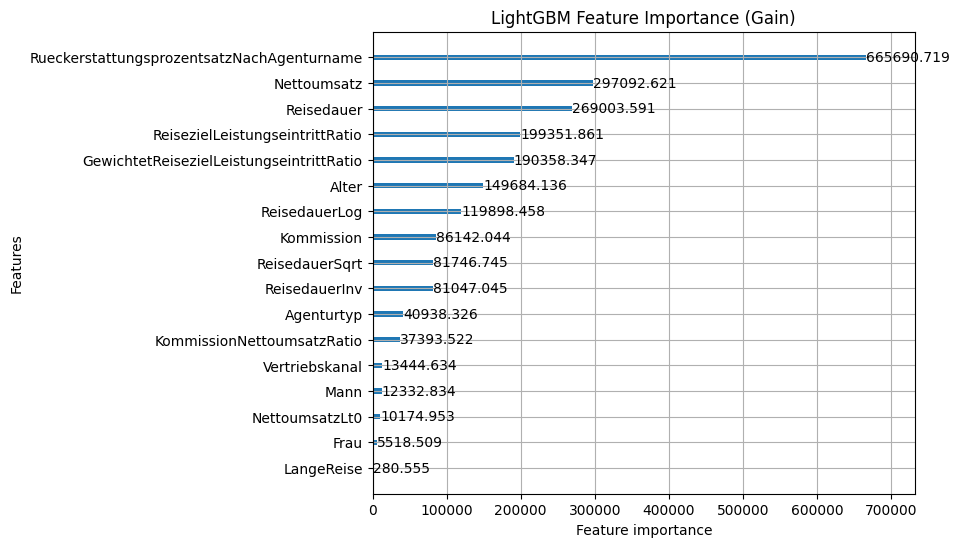

In [62]:
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

0.5682037732326974
TP: 380, FP: 3422, TN: 43339, FN: 315
Recall: 0.547
F1-Score: 0.169


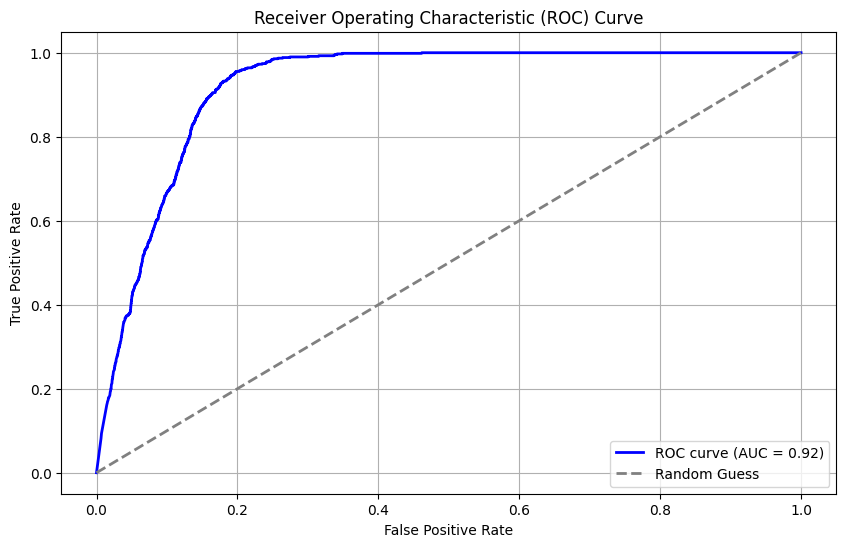

5%	- 10924, 	 0-5% - 10924, 	 True sum: 0 	 True mean: 0.00
10%	- 20678, 	 5-10% - 9754, 	 True sum: 0 	 True mean: 0.00
15%	- 27443, 	 10-15% - 6765, 	 True sum: 1 	 True mean: 0.00
20%	- 31715, 	 15-20% - 4272, 	 True sum: 4 	 True mean: 0.00
25%	- 35395, 	 20-25% - 3680, 	 True sum: 10 	 True mean: 0.00
30%	- 38247, 	 25-30% - 2852, 	 True sum: 32 	 True mean: 0.01
35%	- 40079, 	 30-35% - 1832, 	 True sum: 52 	 True mean: 0.03
40%	- 41021, 	 35-40% - 942, 	 True sum: 56 	 True mean: 0.06
45%	- 42068, 	 40-45% - 1047, 	 True sum: 67 	 True mean: 0.06
50%	- 43654, 	 45-50% - 1586, 	 True sum: 93 	 True mean: 0.06
55%	- 45241, 	 50-55% - 1587, 	 True sum: 122 	 True mean: 0.08
60%	- 47456, 	 55-60% - 2215, 	 True sum: 258 	 True mean: 0.12
65%	- 47456, 	 60-65% - 0, 	 True sum: 0 	 True mean: nan
70%	- 47456, 	 65-70% - 0, 	 True sum: 0 	 True mean: nan
75%	- 47456, 	 70-75% - 0, 	 True sum: 0 	 True mean: nan
80%	- 47456, 	 75-80% - 0, 	 True sum: 0 	 True mean: nan
85%	- 47456, 	 80-

In [63]:
estimate_model(lgb_classifier, X_train, y_train)

In [64]:
df.describe()

,Agenturtyp,Vertriebskanal,Leistungseintritt,Reisedauer,Nettoumsatz,Kommission,Alter,ReisedauerLog,ReisedauerSqrt,ReisedauerInv,LangeReise,NettoumsatzLt0,KommissionNettoumsatzRatio,Mann,Frau,RueckerstattungsprozentsatzNachAgenturname,ReisezielLeistungseintrittRatio,GewichtetReisezielLeistungseintrittRatio
count,63275.000000,63275.000000,63275.00000,63275.000000,63275.00000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000,63275.000000
mean,0.275290,0.982521,0.01465,48.059834,41.93364,9.773201,39.961644,3.196191,5.758693,0.092548,0.030470,0.010715,0.179405,0.147467,0.139945,1.465034,0.014799,0.014679
std,0.446664,0.131050,0.12015,73.145498,47.57243,19.709824,14.002054,1.160747,3.859730,0.142950,0.171878,0.102959,0.223477,0.354574,0.346932,2.072643,0.015171,0.014612
min,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,0.000000,1.000000,0.00000,9.000000,18.50000,0.000000,35.000000,2.302585,3.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.555255,0.004000,0.004000
50%,0.000000,1.000000,0.00000,22.000000,27.00000,0.000000,36.000000,3.135494,4.690416,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.555255,0.007000,0.007000
75%,1.000000,1.000000,0.00000,53.000000,49.50000,11.550000,43.000000,3.988984,7.280110,0.111111,0.000000,0.000000,0.350000,0.000000,0.000000,1.002331,0.015000,0.015000
max,1.000000,1.000000,1.00000,450.000000,810.00000,283.500000,118.000000,6.111467,21.213203,1.000000,1.000000,1.000000,0.650000,1.000000,1.000000,6.631911,0.143000,0.067000


In [65]:
df.columns

Index(['Agenturtyp', 'Vertriebskanal', 'Leistungseintritt', 'Reisedauer',
       'Nettoumsatz', 'Kommission', 'Alter', 'ReisedauerLog', 'ReisedauerSqrt',
       'ReisedauerInv', 'LangeReise', 'NettoumsatzLt0',
       'KommissionNettoumsatzRatio', 'Mann', 'Frau',
       'RueckerstattungsprozentsatzNachAgenturname',
       'ReisezielLeistungseintrittRatio',
       'GewichtetReisezielLeistungseintrittRatio'],
      dtype='object')

In [72]:
def export_variables(file_path, **variables):
    with open(file_path, 'wb') as f:
        pickle.dump(variables, f)
    print(f"Variables saved in {file_path}")


export_variables("variables.pkl", data_transformers=data_transformers, lgb_classifier=lgb_classifier)

Variables saved in variables.pkl
